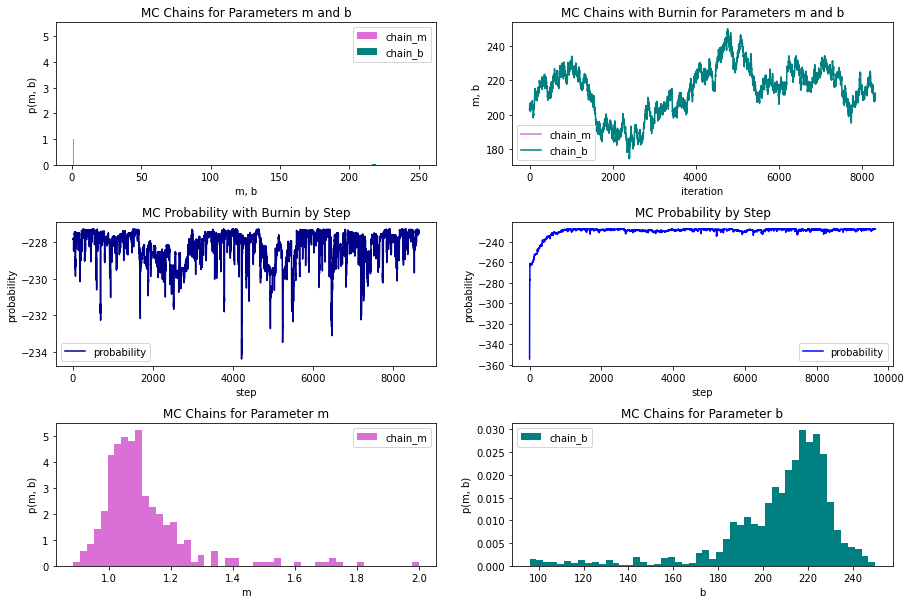

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

# load file
data = np.genfromtxt('data_yerr.dat', names = True, comments = '#', delimiter = '&')
x = data['x']
y = data['y']
sigma_y = data['sigm_y']

def build_model(m, b):
    def model(x):
        return m * x + b
    return model

# likelihood 
def lnlikelihood(m, b, x = x, y = y, sigma_y = sigma_y):
    model = build_model(m, b)
    lnlike = -.5*np.sum(np.log(2*np.pi*sigma_y**2)) - np.sum((y - model(x))**2/(2*sigma_y**2)) 
    return lnlike

m = 2.
b = 100.

# create a posterior distribution, reducing the posterior distirution with prior = 1 and no normalization factor
def post_dist(m, b, x = x, y = y, sigma_y = sigma_y):
     return lnlikelihood(m, b, x = x, y = y, sigma_y = sigma_y) 
    
# sample the posterior distribution using the metropolis algorithm 
# define p(x) 
def p(m, b):
    return post_dist(m, b, x = x, y = y, sigma_y = sigma_y)

# define the start of the chain
m_0, b_0 = 2., 100.

m, b = m_0, b_0

p_0 = p(m_0, b_0)

chain_m = [m]
chain_b = [b]

probability= [p_0]

jump = 1.
N = 10000

# once for each iteration, propose a new m, find the probability with the current b and new m and update my chain if 
# I accpet this new m; regardless of accepting the new m or not, suggest a move for b; update the b chain if I accept 
# the new b
for n in range(N):
    m_1 = norm.rvs(loc = m, scale = jump)
    
    p_m1 = p(m_1, b)
    
    rand_m1 = np.log(np.random.uniform())
    alpha_m1 = p_m1 - p_0
    
    if alpha_m1 > rand_m1:
        m = m_1
        p_0 = p_m1
        
        chain_m.append(m)
        probability.append(p_0)
    
    b_1 = norm.rvs(loc = b, scale = jump)
    
    p_b1 = p(m, b_1)
    
    rand_b1 = np.log(np.random.uniform())
    alpha_b1 = p_b1 - p_0
    
    if alpha_b1 > rand_b1:
        b = b_1
        p_0 = p_b1
        
        chain_b.append(b)
        probability.append(p_0)

burnin = 1000

fig, ax = plt.subplots(3, 2, figsize = (15, 10))
plt.subplots_adjust(hspace = 0.4)

ax[0, 0].hist(chain_m, color = 'orchid', density = True, bins = 50, label = 'chain_m')
ax[0, 0].hist(chain_b, color = 'teal', density = True, bins = 50, label = 'chain_b')
ax[0, 0].set_xlabel('m, b')
ax[0, 0].set_ylabel('p(m, b)')
ax[0, 0].set_title('MC Chains for Parameters m and b')
ax[0, 0].legend();

ax[0, 1].plot(chain_m[burnin:], color = 'orchid', label = 'chain_m')
ax[0, 1].plot(chain_b[burnin:], color = 'teal', label = 'chain_b')
ax[0, 1].set_xlabel('iteration')
ax[0, 1].set_ylabel('m, b')
ax[0, 1].set_title('MC Chains with Burnin for Parameters m and b')
ax[0, 1].legend();

ax[1, 0].plot(probability[burnin:], color = 'darkblue', label ='probability')
ax[1, 0].set_xlabel('step')
ax[1, 0].set_ylabel('probability')
ax[1, 0].set_title('MC Probability with Burnin by Step')
ax[1, 0].legend();

ax[1, 1].plot(probability, color = 'blue', label ='probability')
ax[1, 1].set_xlabel('step')
ax[1, 1].set_ylabel('probability')
ax[1, 1].set_title('MC Probability by Step')
ax[1, 1].legend();

ax[2, 0].hist(chain_m, color = 'orchid', density = True, bins = 50, label = 'chain_m')
ax[2, 0].set_xlabel('m')
ax[2, 0].set_ylabel('p(m, b)')
ax[2, 0].set_title('MC Chains for Parameter m')
ax[2, 0].legend();

ax[2, 1].hist(chain_b, color = 'teal', density = True, bins = 50, label = 'chain_b')
ax[2, 1].set_xlabel('b')
ax[2, 1].set_ylabel('p(m, b)')
ax[2, 1].set_title('MC Chains for Parameter b')
ax[2, 1].legend();

The plot labled 'MC Chains with Burnin for Parameters m and b' does not visually represent the MC algorithm so instead each chain is plotted separately in the plots labeled 'MC Chains with Burnin for Parameter m' and 'MC Chains with Burnin for Parameter b'. When the algorithm is run repeatedly the parameter estimates remain consistent so even though the plot 'MC Probability with Burnin by Step' is not as robust as I would like, I have confidence in the parameter estimations from my sampling. If there was correlation between parameters I would expect to see a chain for m on the plot 'MC Chains with Burnin for Parameters m and b' that moved proportional to the chain for b. Since no m chain appears I cannot draw any conclusions about whether or not the parameters are correlated. 

The plot below labeled 'Lines of Best Fit from Sampled Posterior and Data' shows what I expected from the quality of my MC run as evidenced in the plot 'MC Probability with Burnin by Step': using the mean and median values from my chains that estimate the parameters m and b I can recover lines that capture the gist of the data and that mirror the line produced from a chi^2 minimzation. This means that the model works, and the MC algorithm sampled reasonable estimates from my simplified posterior. I do think that fit resulting from the sampling could be improved.Cropping outliers and normalizing the posterior distribition should improve the fit of this simplified model. If, at that point, the model is still not great then it may be time to adjust the linear model. 

In [2]:
# perform a chi^2 minimization to estimate the parameters m, b
from scipy.optimize import minimize

x0 = np.array([m, b])
res = minimize(lambda x:-lnlikelihood(x[0], x[1]), x0)

test_x = np.linspace(50, 300, 10)

best_fit_m = res.x[0]
best_fit_b = res.x[1]
best_fit_model = build_model(best_fit_m, best_fit_b)

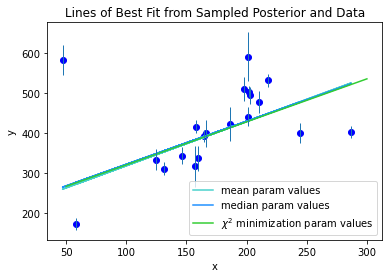

In [3]:
# plot model lines using the mean and median values from each chain to show that the 
# algorithm returned reasonable estimated parameter values
mean_m = np.mean(chain_m)
mean_b = np.mean(chain_b)

med_m = np.median(chain_m)
med_b = np.median(chain_b)

plt.scatter(x, y, color = 'blue')
plt.plot(x, mean_m * x + mean_b, color = 'mediumturquoise', label = 'mean param values')
plt.plot(x, med_m * x + med_b, color = 'dodgerblue', label = 'median param values')
plt.plot(test_x, best_fit_model(test_x), color = 'limegreen', label = '$\chi^2$ minimization param values')
plt.errorbar(x, y, sigma_y, linewidth = 0, elinewidth = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lines of Best Fit from Sampled Posterior and Data')
plt.legend();

/tmp/ipykernel_332/560435097.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gia40nd = gia40[no_dwarf]


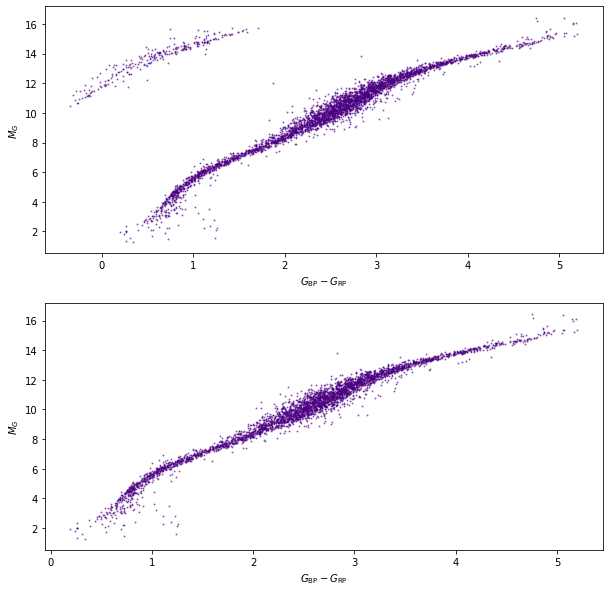

In [4]:
# 510 PROBELM
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

# load data 
gia = pd.read_csv('gaiaedr3_solar_neighborhood.csv')

brightness = gia['mg']
color = gia['bp_rp']
parallax = gia['parallax']

# cut on parallax and assign new variables 
close_cut = gia.parallax > 40
gia40 = gia[close_cut]

# cut out the white dwarfs
no_dwarf =  (color > 2) | (brightness < 9)
gia40nd = gia40[no_dwarf]

brightness40 = gia40['mg']
color40 = gia40['bp_rp']
parallax40 = gia40['parallax']

brightness40nd = gia40nd['mg']
color40nd = gia40nd['bp_rp']
parallax40nd = gia40nd['parallax']

# plot to confirm that I cut the white dwarfs
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

ax[0].scatter(color40, brightness40, s = 1, alpha = 0.5, color = 'indigo')
#ax[0].gca().invert_yaxis()
ax[0].set_xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
ax[0].set_ylabel(r"$M_G$");

ax[1].scatter(color40nd, brightness40nd, s = 1, alpha = 0.5, color = 'indigo')
#ax[1].gca().invert_yaxis()
ax[1].set_xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
ax[1].set_ylabel(r"$M_G$");

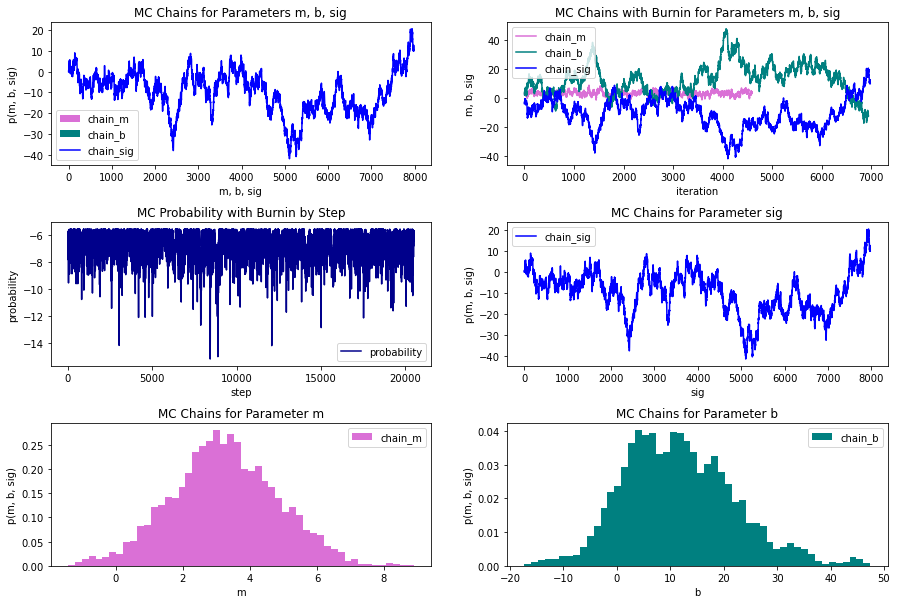

In [7]:
# create a model for the data assuming a linear relationship and some noise term that skews y-data
def gia40nd_model(m, b, sig):
    def model(color40nd):
        return m * color40nd + b + sig
    return model

# define the likelihood with a prior normal distribution for the noise using a std of 5 and a mean that ensures only
# postive values from the distribution
sigma_mg = np.random.normal(loc = 100, scale = 5)

def lnlikelihood(m, b, sig, x = color40nd, y = brightness40nd):
    model = gia40nd_model(m, b, sig)
    lnlike = -.5*np.sum(np.log(2*np.pi*sigma_mg**2)) - np.sum((y - model(color40nd))**2/(2*sigma_mg**2)) 
    return lnlike

# assume a uniform prior of 1 for my parameters m and b; the prior for the noise is built into the
# likelihood; create a posterior distribution 
def post(m, b, sig):
    return lnlikelihood(m, b, sig, x = color40nd, y = brightness40nd) 

# run the MC sampling 
def p(m, b, sig):
    return post(m, b, sig)

# define the start of the chain
m_0 = 0.
b_0 = 0.
sig_0 = 0.

m = m_0
b = b_0
sig = sig_0

p_0 = p(m_0, b_0, sig_0)

chain_m = [m]
chain_b = [b]
chain_sig = [sig]

probability= [p_0]

jump = 1.
N = 10000

# sample
for n in range(N):
    m_1 = norm.rvs(loc = m, scale = jump)
    
    p_m1 = p(m_1, b, sig)
    
    rand_m1 = np.log(np.random.uniform())
    alpha_m1 = p_m1 - p_0
    
    if alpha_m1 > rand_m1:
        m = m_1
        p_0 = p_m1
        
        chain_m.append(m)
        probability.append(p_0)
    
    b_1 = norm.rvs(loc = b, scale = jump)
    
    p_b1 = p(m, b_1, sig)
    
    rand_b1 = np.log(np.random.uniform())
    alpha_b1 = p_b1 - p_0
    
    if alpha_b1 > rand_b1:
        b = b_1
        p_0 = p_b1
        
        chain_b.append(b)
        probability.append(p_0)
    
    sig_1 = norm.rvs(loc = sig, scale = jump)
    
    p_sig1 = p(m, b, sig_1)
    
    rand_sig1 = np.log(np.random.uniform())
    alpha_sig1 = p_sig1 - p_0
    
    if alpha_sig1 > rand_sig1:
        sig = sig_1
        p_0 = p_sig1
        
        chain_sig.append(sig)
        probability.append(p_0)

# plot
burnin = 1000

fig, ax = plt.subplots(3, 2, figsize = (15, 10))
plt.subplots_adjust(hspace = 0.4)

ax[0, 0].hist(chain_m, color = 'orchid', density = True, bins = 50, label = 'chain_m')
ax[0, 0].hist(chain_b, color = 'teal', density = True, bins = 50, label = 'chain_b')
ax[0, 0].plot(chain_sig, color = 'blue', label ='chain_sig')
ax[0, 0].set_xlabel('m, b, sig')
ax[0, 0].set_ylabel('p(m, b, sig)')
ax[0, 0].set_title('MC Chains for Parameters m, b, sig')
ax[0, 0].legend();

ax[0, 1].plot(chain_m[burnin:], color = 'orchid', label = 'chain_m')
ax[0, 1].plot(chain_b[burnin:], color = 'teal', label = 'chain_b')
ax[0, 1].plot(chain_sig[burnin:], color = 'blue', label ='chain_sig')
ax[0, 1].set_xlabel('iteration')
ax[0, 1].set_ylabel('m, b, sig')
ax[0, 1].set_title('MC Chains with Burnin for Parameters m, b, sig')
ax[0, 1].legend();

ax[1, 0].plot(probability[burnin:], color = 'darkblue', label ='probability')
ax[1, 0].set_xlabel('step')
ax[1, 0].set_ylabel('probability')
ax[1, 0].set_title('MC Probability with Burnin by Step')
ax[1, 0].legend();

ax[1, 1].plot(chain_sig, color = 'blue', label ='chain_sig')
ax[1, 1].set_xlabel('sig')
ax[1, 1].set_ylabel('p(m, b, sig)')
ax[1, 1].set_title('MC Chains for Parameter sig')
ax[1, 1].legend();

ax[2, 0].hist(chain_m, color = 'orchid', density = True, bins = 50, label = 'chain_m')
ax[2, 0].set_xlabel('m')
ax[2, 0].set_ylabel('p(m, b, sig)')
ax[2, 0].set_title('MC Chains for Parameter m')
ax[2, 0].legend();

ax[2, 1].hist(chain_b, color = 'teal', density = True, bins = 50, label = 'chain_b')
ax[2, 1].set_xlabel('b')
ax[2, 1].set_ylabel('p(m, b, sig)')
ax[2, 1].set_title('MC Chains for Parameter b')
ax[2, 1].legend();

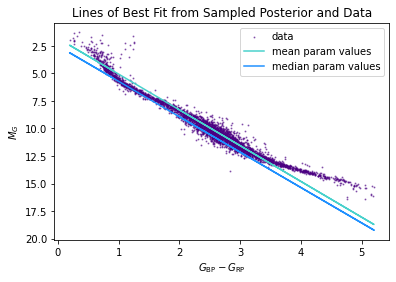

In [8]:
# plot model lines using the mean and median values from each chain to show that the 
# algorithm returned reasonable estimated parameter values
mean_m = np.mean(chain_m)
mean_b = np.mean(chain_b)
mean_sig = np.mean(chain_sig)

med_m = np.median(chain_m)
med_b = np.median(chain_b)
med_sig = np.median(chain_sig)

plt.scatter(color40nd, brightness40nd, s = 1, color = 'indigo', label = 'data', alpha = 0.5)
plt.plot(color40nd, mean_m * color40nd + mean_b + mean_sig, color = 'mediumturquoise', label = 'mean param values')
plt.plot(color40nd, med_m * color40nd + med_b + med_sig, color = 'dodgerblue', label = 'median param values')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")
plt.gca().invert_yaxis()
plt.title('Lines of Best Fit from Sampled Posterior and Data')
plt.legend();

The plot titled 'Lines of Best Fit from Sampled Posterior and Data' shows that the MC algorithm was able reasonably predict parameter values because the lines that result from using the mean and median parameter values are able to capture most of the data. To create this fit, I inferred a nomally distributed prior on the parameter sig which represents the skew in y. This allowed me to produce a line of reasonable fit, but the skew in y, estimating by eye, is only normally distributed about the mid-portion of the data; the tails of the data are not normally distributed. Accordingly, the model accurately predicts the main sequence, but it does not capture the tails which means that a more complex model is needed fully capture the data.

There are two constraints that I imposed on my parameters: the starting points of each chain and the priors. The priors were not correlated, and they were chosen to best mimic the data. The starting points were correlated because an arbitary starting point of 0 was chosen. There is anti-correlation between the parameters b and sig and no correlation between the parameter and either other parameter. 